# GROUP 36 PROJECT PROPOSAL
### Predicting Water Levels in Venice

**INTRODUCTION:**
For our project, we are going to observe a dataset that describes water levels in Venice, Italy. This dataset contains data from 1983 to 2015, and includes the water level in centimeters for every hour of every day. Our predictive question is:
### “What will the average water level in Venice be ten years from now?” 
We aim to observe possible trends in the average water level per year starting from 1983 and use regression to predict how much the water level will increase or decrease in the future. Since the dataset ends at the year 2015, we want to predict the water level ten years from that, in 2025. 


**PRELIMINARY DATA ANALYSIS**

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(tidyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We first loaded in our dataset and noticied the original dataset had some untidy data. This data was untidy because the original dataset had year, month, date, and and time all in one column, so we separated these into different columns with one value per cell. 
We used all the data from the original dataset, and did not need to remove any variables, as the dataset contains all the information we need already; the different water levels and the time at which they were recorded. 

In [2]:
data<-read_csv('venezia.csv') |>separate(col=datetime, into=c('Year', 'Month', 'Date'), sep='-', convert=TRUE) |>
                                separate(col=Date, into=c('Day', 'Time'), sep=" ", convert=TRUE)

data

Rows: 289272 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (1): level
dttm (1): datetime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Year,Month,Day,Time,level
<int>,<int>,<int>,<chr>,<dbl>
1983,1,1,01:00:00,44
1983,1,1,02:00:00,35
1983,1,1,03:00:00,23
1983,1,1,04:00:00,10
1983,1,1,05:00:00,1
1983,1,1,06:00:00,-1
1983,1,1,07:00:00,6
1983,1,1,08:00:00,17
1983,1,1,09:00:00,31


Initially we wanted to look at just the first day of every month at a specific time, for example; 12 pm of every first day. However, we realized that this does not account for high and low tide periods of each day. Therefore, we changed our method to take the mean water level of the entire day, as this takes into consideration different tides throughout the day. From there we grouped by year and found the mean water level of each year. We also had to remove data for 2016 becuase there was only 1 data point for 2016 while the other years had thousands of data points, which would result in an outlier when plotting mean water level.

In [3]:
set.seed(2000) 

filtered_data <- data |>  
filter( Day == "1") |>
filter( Year != "2016")

mean_daily_data <- filtered_data |> 
group_by(Year, Month, Day) |>
summarize(mean_daily = mean(level))

mean_yearly_data <- mean_daily_data |>
group_by(Year) |>
summarize(mean_yearly = mean(mean_daily))

data_split <- initial_split(mean_yearly_data, prop = 0.8, strata = mean_yearly)
training_data <- training(data_split)
testing_data <- testing(data_split)

mean_yearly_data
training_data
testing_data

`summarise()` has grouped output by 'Year', 'Month'. You can override using the
`.groups` argument.
Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 1 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


Year,mean_yearly
<int>,<dbl>
1983,21.30495
1984,22.61458
1985,18.47917
1986,23.38542
1987,20.69444
1988,21.61806
1989,18.93750
1990,18.20486
1991,16.39931


Year,mean_yearly
<int>,<dbl>
1983,21.30495
1985,18.47917
1986,23.38542
1987,20.69444
1988,21.61806
1989,18.93750
1990,18.20486
1991,16.39931
1992,17.53819


Year,mean_yearly
<int>,<dbl>
1984,22.61458
1994,20.85417
1995,18.96181
1998,30.56250
2004,31.75694
2005,26.73611
2013,33.06597


For spliting the data we chose a 80/20 split as we didnt have many data points to start with. We want to predict the yearly average for future years, therefore we split the data after wrangling so the testing and training data were both the same format(yearly average). We then visualized our data using a line plot with points.

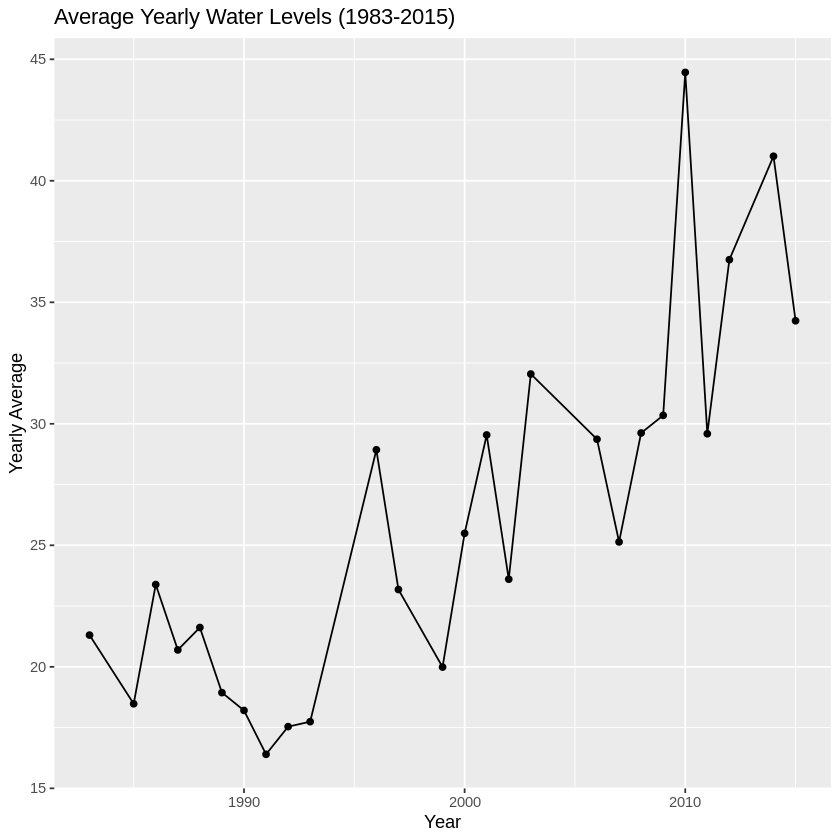

In [4]:
graph_data <- training_data |>
ggplot(aes( x = Year, y = mean_yearly))+
geom_point()+
geom_line() +
labs( x = "Year", y = "Yearly Average", title = "Average Yearly Water Levels (1983-2015)")

graph_data

**Methodology:** 
* Our goal within this project is to $predict$ $future$ $trends$ of Venice's water level
* We plan on doing so through using a K-nearest neighbors regression model to create a $regression$ $line$ which will allow us to predict future trends within our data, hence allowing us to answer our predictive question. 
* We will be implemented our regression model onto a $line plot$ which will contain "Year" on the y-axis and "Yearly Average" on the y axis, as well as the regression line will be coloured as it's overlay without color differentiation may cause confusion while interpreting the graph.
* Overall as we have not yet covered chapter 8 (Regression II), there are likely additional elements which will be incorporated into this project as our knowledge increases


**EXPECTED OUTCOMES/SIGNIFICANCE:** We expect to find increasing water levels as the years progress, which corresponds to water levels rising all around the world due to global warming. The results we predict will likely reflect the impact global warming has on the environment. This can lead to more exploratory questions asking what factors are causing the water levels to change. 
